In [15]:
import pandas as pd
import numpy as np
import os
import sys
import re
from platform import python_version
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from util import set_default_style

print(python_version())

np.__version__, pd.__version__ # for pickle

3.10.16


('1.26.4', '2.2.3')

In [16]:
def get_lambda_values(folder):
    # Use a non-greedy regex to capture the lambda part.
    pattern = re.compile(r'lambd_(.+?)_fold_')
    lambda_set = set()
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder):
        match = pattern.search(filename)
        if match:
            # Extract lambda value (as a string)
            lambda_value = match.group(1)
            lambda_set.add(lambda_value)
    
    # Sort the lambda values by converting to float for numerical sorting.
    # The result remains a list of strings in their original format.
    sorted_lambda_values = sorted(lambda_set, key=lambda x: float(x))
    return sorted_lambda_values

get_lambda_values("dataset_lam0.1_10x_long")

['0.0',
 '0.01',
 '0.05',
 '0.1',
 '0.15',
 '0.2',
 '0.25',
 '0.3',
 '0.35',
 '0.4',
 '0.45',
 '0.5',
 '0.55',
 '0.6',
 '0.65',
 '0.7',
 '0.75',
 '0.8',
 '0.85',
 '0.9',
 '0.95',
 '1.0',
 '1.5',
 '2.0']

In [17]:
#dataset_values = ["0.0", "0.01", "0.05", "0.1", "0.2"]
#lambda_values = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
n_folds = 5

dataset_lam0.0_10x_long 0.0
dataset_lam0.1_10x_long 0.1
dataset_lam0.2_10x_long 0.2


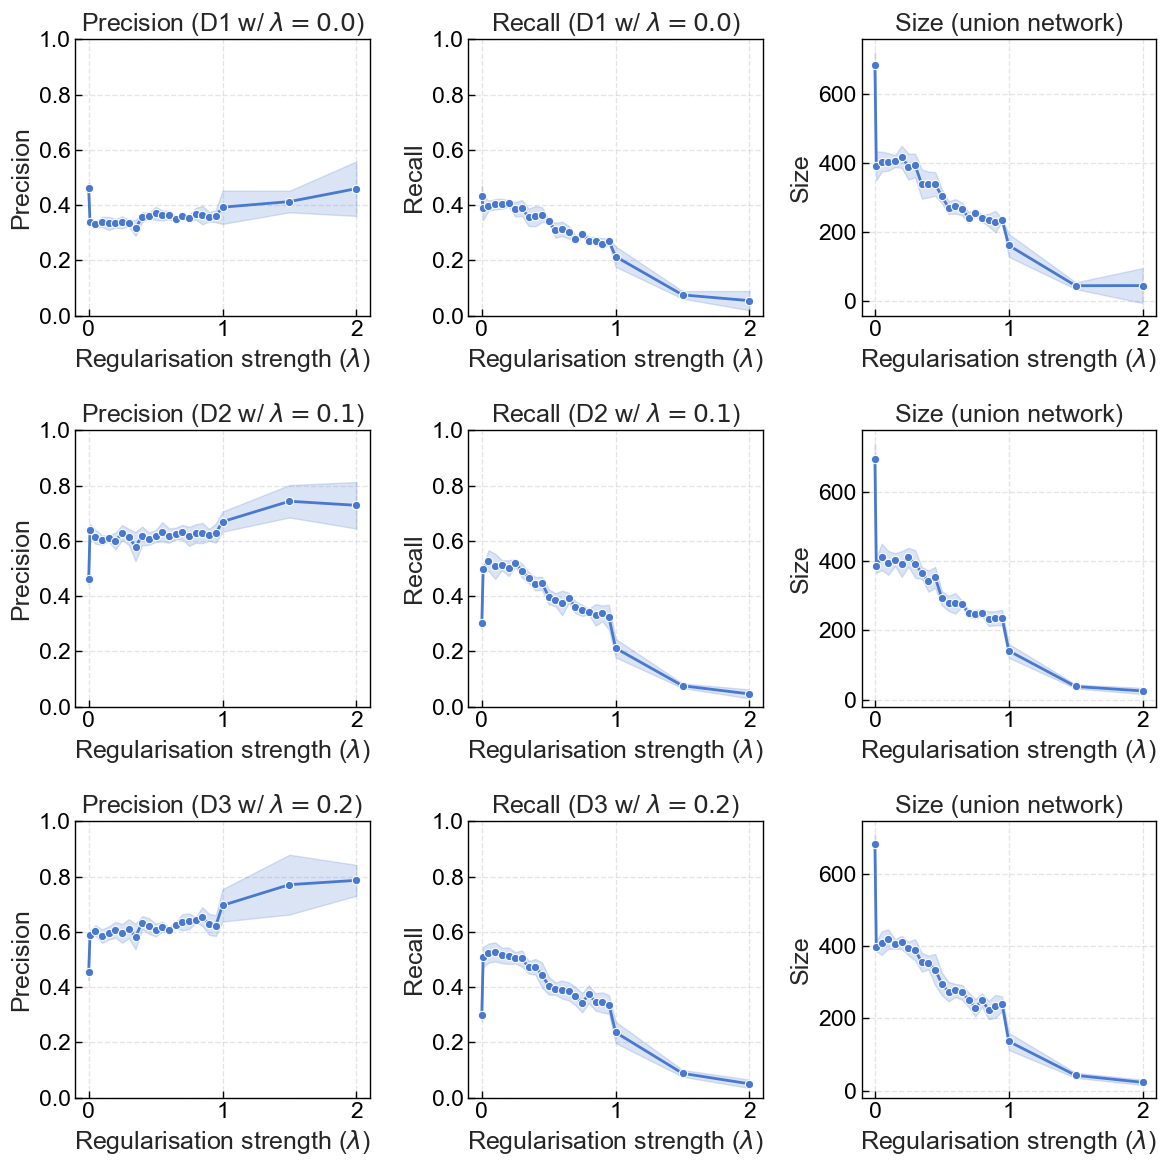

In [26]:
set_default_style(font_scale=1.5)

#sns.set_theme(style="whitegrid", context="talk")
#sns.set_theme(style="whitegrid")

dataset_values = ["dataset_lam0.0_10x_long", "dataset_lam0.1_10x_long", "dataset_lam0.2_10x_long"]

# List to collect precision and recall for each (dataset, lambda, fold)
results = []

# If true, instead of prec/recall on the stacked vector for all samples,
# it does so on the union network (across samples)
compare_union = False

# Iterate over datasets first (using dataset_values), then over lambda files, then over folds.
for dataset in dataset_values:
    # read ground truth
    gt_dataset_lam = dataset.split("lam")[1].split("_")[0]
    print(dataset, gt_dataset_lam)
    inputs, graph = pd.read_pickle(f"dataset_10x_lambd{gt_dataset_lam}.pkl")
    df_gt = pd.read_pickle(f"ground_truth_10x_lambd{gt_dataset_lam}.pkl")
    lambda_values = get_lambda_values(dataset)
    avg_gt = df_gt.abs().mean(axis=1)
    for lambd in lambda_values:
        for fold in range(n_folds):
            # Build the file path:
            # Folder name uses the dataset value (lam), while file name uses the lambda value (lambd).
            file_path = f"{dataset}/avg_sol__reps_10_lambd_{lambd}_fold_{fold}.pkl"
            try:
                df_result = pd.read_pickle(file_path)
            except FileNotFoundError:
                print(f"File not found: {file_path}")
                continue

            # In case there are duplicate indices, average over them.
            df_result = df_result.groupby(level=0).mean()

            # For y_true, we compute which reactions were selected in any condition
            # my computing the mean across samples, then assigning 1 if at least 1 sample
            # uses this edge.
            if compare_union:
                y_true = (df_gt.mean(axis=1) > 0).astype(int)
            else:
                y_true = (df_gt>0).astype(int).stack().to_numpy()
            
            # We do the same with the predicted network, which was inferred only with
            # partial information about the TFs (which were removed in cross val 5-fold setting)
            if compare_union:
                y_pred = df_result.loc[df_gt.index].mean(axis=1)
            else:
                y_pred = (df_result.loc[df_gt.index] > 0).astype(int).stack().to_numpy()
            # Total number of different edges selected
            sel_edges = (df_result.abs().mean(axis=1)>0).sum()

            # Compute precision and recall (using a threshold of 0 for predictions)
            prec = precision_score(y_true, (y_pred > 0).astype(int))
            rec = recall_score(y_true, (y_pred > 0).astype(int))

            results.append({
                "dataset": dataset,
                "lambda": lambd,
                "fold": fold,
                "precision": prec,
                "recall": rec,
                "size": sel_edges
            })

# Convert the list of results into a DataFrame.
df_results = pd.DataFrame(results)
df_results["lambda"] = df_results["lambda"].astype(float)

# ---------------- Plotting ----------------

# We'll create one row per dataset.
datasets = sorted(df_results['dataset'].unique())
n_datasets = len(datasets)

# Create subplots with 2 columns (precision and recall) and one row per dataset.
# sharex and sharey ensure that all plots use the same x- and y-axis scales.
fig, axes = plt.subplots(n_datasets, 3, figsize=(12, 4 * n_datasets), sharex=False, sharey=False)

# If there is only one dataset, force axes to be 2D.
if n_datasets == 1:
    axes = np.array([axes])

for i, ds in enumerate(datasets):
    data = df_results[df_results['dataset'] == ds]
    lam = ds.split("lam")[1].split("_")[0]
    
    # --- Precision Plot ---
    ax_prec = axes[i, 0]
    ax_prec.set_ylim([0, 1])
    
    # Use Seaborn's lineplot with errorbar="sd" to get a shaded standard deviation.
    sns.lineplot(x="lambda", y="precision", data=data,
                 errorbar="sd", marker="o", linewidth=2, ax=ax_prec)
    ax_prec.set_title(f"Precision (D{i+1} w/ $\lambda={lam}$)")
    ax_prec.set_xlabel("Regularisation strength ($\lambda$)")
    ax_prec.set_ylabel("Precision")
    
    # --- Recall Plot ---
    ax_rec = axes[i, 1]
    ax_rec.set_ylim([0, 1])
    sns.lineplot(x="lambda", y="recall", data=data,
                 errorbar="sd", marker="o", linewidth=2, ax=ax_rec)
    ax_rec.set_title(f"Recall (D{i+1} w/ $\lambda={lam}$)")
    ax_rec.set_xlabel("Regularisation strength ($\lambda$)")
    ax_rec.set_ylabel("Recall")

    # -- Size ---
    ax_rec = axes[i, 2]
    sns.lineplot(x="lambda", y="size", data=data,
                 errorbar="sd", marker="o", linewidth=2, ax=ax_rec)
    ax_rec.set_title(f"Size (union network)")
    ax_rec.set_xlabel("Regularisation strength ($\lambda$)")
    ax_rec.set_ylabel("Size")

#plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("sim_carnival.pdf")
plt.show()
